<a href="https://colab.research.google.com/github/pkhambat1/cs1430-let-me-take-a-nerfie/blob/main/let_me_take_a_nerfie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Hi!

Thanks for stopping by the let-me-take-a-nerfie notebook! We are team Let Me Take a NeRFie (Aditya Parameswaran, Gaurav Sharma, Pezanne Khambatta, Prashanthi Ramachandran)

We've made this notebook for you to be able to train your very own NeRF without any configuration hassles or hardware mismatches. Have fun!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#GPU CHECK

In [3]:
!nvidia-smi

Wed May 11 02:41:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Download Helper Code and Input Files

Download NeRF Synthetic Data

In [ ]:
!mkdir -p nerf_example_data
%cd nerf_example_data
!wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip
!unzip nerf_example_data.zip
!rm nerf_example_data.zip
%cd ..

Clone Nvidia's Instant-NGP

In [23]:
!git clone https://github.com/NVlabs/instant-ngp.git

Cloning into 'instant-ngp'...
remote: Enumerating objects: 1872, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 1872 (delta 57), reused 84 (delta 42), pack-reused 1744
Receiving objects: 100% (1872/1872), 185.28 MiB | 40.86 MiB/s, done.
Resolving deltas: 100% (1024/1024), done.


Clone let-me-take-a-nerfie (our project)

In [25]:
!git clone https://github.com/pkhambat1/cs1430-let-me-take-a-nerfie.git
%cd cs1430-let-me-take-a-nerfie/

fatal: destination path 'cs1430-let-me-take-a-nerfie' already exists and is not an empty directory.
/content/torch-ngp/cs1430-let-me-take-a-nerfie


#IMPORTS

Install TinyCUDA (Not required for now)

In [26]:
# !pip install git+https://github.com/NVlabs/tiny-cuda-nn/#subdirectory=bindings/torch

requirements.txt

In [7]:
!pip3 install -r requirements.txt

In [27]:
import torch
torch.cuda.is_available()

True

In [28]:
!ls

activation.py	environment.yml  main_nerf.py  readme.md	 shencoder
colmap2nerf.py	gridencoder	 nerf	       requirements.txt  tanks2nerf.py
encoding.py	LICENSE		 raymarching   scripts		 testing


#BUILD CUDA PACKAGES

In [29]:
!chmod +x scripts/*

In [30]:
!./scripts/install_ext.sh

Processing /content/torch-ngp/cs1430-let-me-take-a-nerfie/raymarching
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for raymarching: filename=raymarching-0.0.0-cp37-cp37m-linux_x86_64.whl size=1282164 sha256=4acafac48670904eb37c892c0476b013615f2a2fa61736b4f817b88a6bbe76fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-o041jze9/wheels/f7/a4/aa/5678fab93bf14fd32b553b64dab5e4ba0d793d319cd41c6791
Successfully built raymarching
  Attempting uninstall: raymarching
    Found existing installation: raymarching 0.0.0
    Uninstalling raymarching-0.0.0:
      Successfully uninstalled raymarching-0.0.0
Processing /content/torch-ngp/cs

##Train

In [12]:
# !python main_nerf.py ../instant-ngp/data/nerf/fox --workspace trial_nerf --fp16 

#Test

In [13]:
# !python main_nerf.py ../instant-ngp/data/nerf/fox --workspace trial_nerf --fp16 --test

#HYPERPARAMETER TUNING

Visualize GridEncoder

In [14]:
from gridencoder import GridEncoder

In [31]:
# Sample hyperparams
hp = {
  'd': 3, 
  'L': 16,
  'F': 2,
  'N_min': 16,
  'b': 1.26,
  'gridtype': 'hash',
  'log2_hashmap_size': 19,
} 

offsets tensor([      0,    4913,   15561,   35244,   74548,  148636,  289244,  576740,
        1101028, 1625316, 2149604, 2673892, 3198180, 3722468, 4246756, 4771044,
        5295332], dtype=torch.int32)


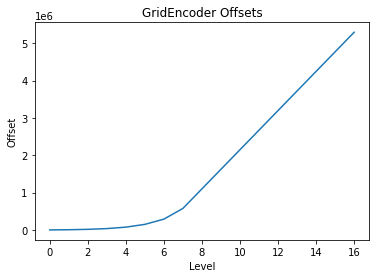

In [32]:
ge = GridEncoder(**hp)

Define hyperparams

In [33]:
import pickle
import numpy as np
import os

In [34]:
hyperparams = []

# b_vals = np.linspace(1.38, 2, 4)
b_vals = [2]
F_vals = [2, 4, 8]


for b in b_vals:
  for f in F_vals:
    hp = {
      'd': 3, 
      'L': 16,
      'F': f,
      'N_min': 16,
      # 'b': b,
      'gridtype': 'hash',
      'log2_hashmap_size': 19,
    } 
    hyperparams.append(hp)
  

Save hyperparams

In [35]:
!mkdir -p gridencoder/hyperparams

In [36]:
for i, hp in enumerate(hyperparams):
  with open(f'gridencoder/hyperparams/hp_F={F_vals[i]}.pickle', 'wb') as f:
      pickle.dump(hp, f)

Train with Hyperparams

In [21]:
!python main_nerf.py ../nerf_example_data/nerf_synthetic/lego/ --workspace trial_nerf_lego --fp16 -hyperparams_path gridencoder/hyperparams/hp_F=4.pickle --mode blender

Namespace(H=1080, O=False, W=1920, bound=2, ckpt='latest', clip_text='', cuda_ray=False, dt_gamma=0.00390625, error_map=False, fovy=50, fp16=True, gui=False, hyperparams_path='gridencoder/hyperparams/hp_F=4.pickle', iters=30000, lr=0.01, max_ray_batch=4096, max_spp=64, mode='blender', num_rays=4096, num_steps=512, path='../nerf_example_data/nerf_synthetic/lego/', preload=False, radius=5, rand_pose=-1, scale=0.33, seed=0, tcnn=False, test=False, upsample_steps=0, workspace='trial_nerf_lego')
offsets tensor([      0,    4913,   20538,   63413,  188413,  561661, 1085949, 1610237,
        2134525, 2658813, 3183101, 3707389, 4231677, 4755965, 5280253, 5804541,
        6328829], dtype=torch.int32)
<Figure size 640x480 with 1 Axes>
self.in_dim_color 16
NeRFNetwork(
  (encoder): GridEncoder: d=3 L=16 F=4 N_min=16 b=1.4472692374403782 params=(6328829, 4) gridtype=hash
  (sigma_net): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=False)
    (1): Linear(in_features=64, out_feat

In [22]:
!python main_nerf.py ../nerf_example_data/nerf_synthetic/lego/ --workspace trial_nerf_lego --fp16 -hyperparams_path gridencoder/hyperparams/hp_F=4.pickle --mode blender --test

Namespace(H=1080, O=False, W=1920, bound=2, ckpt='latest', clip_text='', cuda_ray=False, dt_gamma=0.00390625, error_map=False, fovy=50, fp16=True, gui=False, hyperparams_path='gridencoder/hyperparams/hp_F=4.pickle', iters=30000, lr=0.01, max_ray_batch=4096, max_spp=64, mode='blender', num_rays=4096, num_steps=512, path='../nerf_example_data/nerf_synthetic/lego/', preload=False, radius=5, rand_pose=-1, scale=0.33, seed=0, tcnn=False, test=True, upsample_steps=0, workspace='trial_nerf_lego')
offsets tensor([      0,    4913,   20538,   63413,  188413,  561661, 1085949, 1610237,
        2134525, 2658813, 3183101, 3707389, 4231677, 4755965, 5280253, 5804541,
        6328829], dtype=torch.int32)
<Figure size 640x480 with 1 Axes>
self.in_dim_color 16
NeRFNetwork(
  (encoder): GridEncoder: d=3 L=16 F=4 N_min=16 b=1.4472692374403782 params=(6328829, 4) gridtype=hash
  (sigma_net): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=False)
    (1): Linear(in_features=64, out_featu